In [6]:
import pandas as pd
%matplotlib inline

xl = pd.ExcelFile("pivot_test.xlsx", index_col=0)
df = xl.parse("Sheet1")
df
    

,NetworkAService.getEdges,AdminService.getStatus,NetworkAService.getNetworkUserMemberships,NetworkAService.queryNetwork
0,11,13,NaN,NaN
1,17,12,6.0,3.0
2,12,15,NaN,NaN


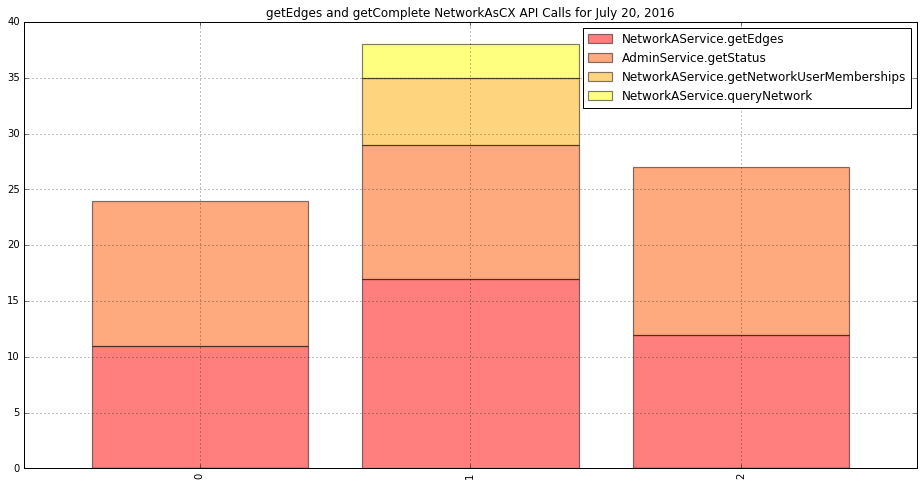

In [7]:
df.plot(kind='bar', grid=True, colormap='autumn', alpha=0.5, figsize=(16,8),\
               title='getEdges and getComplete NetworkAsCX API Calls for July 20, 2016', \
               width=.8, linewidth=1.2, stacked=True)

In [ ]:
create or replace function colpivot(
    out_table varchar, in_query varchar,
    key_cols varchar[], class_cols varchar[],
    value_e varchar, col_order varchar
) returns void as $$
    declare
        in_table varchar;
        col varchar;
        ali varchar;
        on_e varchar;
        i integer;
        rec record;
        query varchar;
        -- This is actually an array of arrays but postgres does not support an array of arrays type so we flatten it.
        -- We could theoretically use the matrix feature but it's extremly cancerogenous and we would have to involve
        -- custom aggrigates. For most intents and purposes postgres does not have a multi-dimensional array type.
        clsc_cols text[] := array[]::text[];
        n_clsc_cols integer;
        n_class_cols integer;
    begin
        in_table := quote_ident('__' || out_table || '_in');
        execute ('create temp table ' || in_table || ' on commit drop as ' || in_query);
        -- get ordered unique columns (column combinations)
        query := 'select array[';
        i := 0;
        foreach col in array class_cols loop
            if i > 0 then
                query := query || ', ';
            end if;
            query := query || 'quote_literal(' || quote_ident(col) || ')';
            i := i + 1;
        end loop;
        query := query || '] x from ' || in_table;
        for j in 1..2 loop
            if j = 1 then
                query := query || ' group by ';
            else
                query := query || ' order by ';
                if col_order is not null then
                    query := query || col_order || ' ';
                    exit;
                end if;
            end if;
            i := 0;
            foreach col in array class_cols loop
                if i > 0 then
                    query := query || ', ';
                end if;
                query := query || quote_ident(col);
                i := i + 1;
            end loop;
        end loop;
        -- raise notice '%', query;
        for rec in
            execute query
        loop
            clsc_cols := array_cat(clsc_cols, rec.x);
        end loop;
        n_class_cols := array_length(class_cols, 1);
        n_clsc_cols := array_length(clsc_cols, 1) / n_class_cols;
        -- build target query
        query := 'select ';
        i := 0;
        foreach col in array key_cols loop
            if i > 0 then
                query := query || ', ';
            end if;
            query := query || '_key.' || quote_ident(col) || ' ';
            i := i + 1;
        end loop;
        for j in 1..n_clsc_cols loop
            query := query || ', ';
            col := '';
            for k in 1..n_class_cols loop
                if k > 1 then
                    col := col || ', ';
                end if;
                col := col || clsc_cols[(j - 1) * n_class_cols + k];
            end loop;
            ali := '_clsc_' || j::text;
            query := query || '(' || replace(value_e, '#', ali) || ')' || ' as ' || quote_ident(col) || ' ';
        end loop;
        query := query || ' from (select distinct ';
        i := 0;
        foreach col in array key_cols loop
            if i > 0 then
                query := query || ', ';
            end if;
            query := query || quote_ident(col) || ' ';
            i := i + 1;
        end loop;
        query := query || ' from ' || in_table || ') _key ';
        for j in 1..n_clsc_cols loop
            ali := '_clsc_' || j::text;
            on_e := '';
            i := 0;
            foreach col in array key_cols loop
                if i > 0 then
                    on_e := on_e || ' and ';
                end if;
                on_e := on_e || ali || '.' || quote_ident(col) || ' = _key.' || quote_ident(col) || ' ';
                i := i + 1;
            end loop;
            for k in 1..n_class_cols loop
                on_e := on_e || ' and ';
                on_e := on_e || ali || '.' || quote_ident(class_cols[k]) || ' = ' || clsc_cols[(j - 1) * n_class_cols + k];
            end loop;
            query := query || 'left join ' || in_table || ' as ' || ali || ' on ' || on_e || ' ';
        end loop;
        -- raise notice '%', query;
        execute ('create temp table ' || quote_ident(out_table) || ' on commit drop as ' || query);
        -- cleanup temporary in_table before we return
        execute ('drop table ' || in_table)
        return;
    end;
$$ language plpgsql volatile;